In [5]:
import pandas as pd
from datetime import datetime
shampoo = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
from pandas.plotting import autocorrelation_plot

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
df = pd.read_csv(shampoo, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
df.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

/var/folders/jl/97zzvf352gg0qn93kb33f4th0000gn/T/ipykernel_5069/982994444.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Mon, 04 Apr 2022   AIC                            408.969
Time:                        20:42:01   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

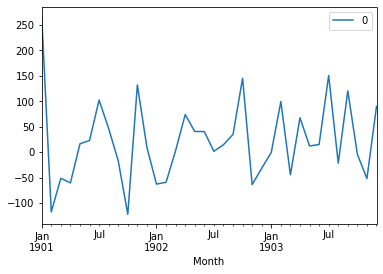

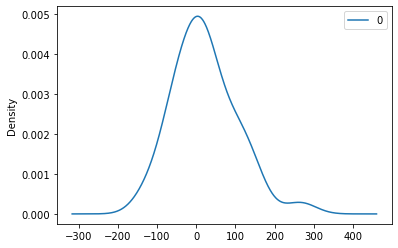

                0
count   36.000000
mean    21.936144
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


In [6]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(shampoo, header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
series.index = series.index.to_period('M')
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

/var/folders/jl/97zzvf352gg0qn93kb33f4th0000gn/T/ipykernel_5069/3874394131.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000
predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220221, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365673, expected=575.500000
predicted=459.415021, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231275, expected=475.300000
predicted=672.914944, expected=581.300000
predicted=531.541449, expected=646.900000
Test RMSE: 89.021


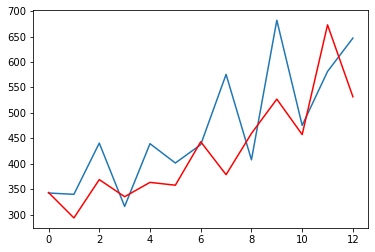

In [7]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(shampoo, header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
series.index = series.index.to_period('M')
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [8]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

shampoo = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(shampoo, header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

/var/folders/jl/97zzvf352gg0qn93kb33f4th0000gn/T/ipykernel_5069/2723928940.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


ARIMA(0, 0, 0) RMSE=228.966
ARIMA(0, 0, 1) RMSE=195.596
ARIMA(0, 0, 2) RMSE=154.886
ARIMA(0, 1, 0) RMSE=133.156
ARIMA(0, 1, 1) RMSE=104.077
ARIMA(0, 1, 2) RMSE=68.345
ARIMA(0, 2, 0) RMSE=255.187
ARIMA(0, 2, 1) RMSE=134.168
ARIMA(0, 2, 2) RMSE=74.644
ARIMA(1, 0, 0) RMSE=152.028
ARIMA(1, 0, 1) RMSE=111.787
ARIMA(1, 0, 2) RMSE=77.086
ARIMA(1, 1, 0) RMSE=88.631
ARIMA(1, 1, 1) RMSE=87.942
ARIMA(1, 1, 2) RMSE=90.986
ARIMA(1, 2, 0) RMSE=134.576
ARIMA(1, 2, 1) RMSE=86.157
ARIMA(1, 2, 2) RMSE=65.511
ARIMA(2, 0, 0) RMSE=100.879
ARIMA(2, 0, 1) RMSE=98.953
ARIMA(2, 0, 2) RMSE=98.688
ARIMA(2, 1, 0) RMSE=85.063
ARIMA(2, 1, 1) RMSE=88.428
ARIMA(2, 1, 2) RMSE=83.497
ARIMA(2, 2, 0) RMSE=97.829
ARIMA(2, 2, 1) RMSE=76.847
ARIMA(2, 2, 2) RMSE=80.807
ARIMA(4, 0, 0) RMSE=100.974
ARIMA(4, 0, 1) RMSE=101.510
ARIMA(4, 0, 2) RMSE=97.932
ARIMA(4, 1, 0) RMSE=95.068
ARIMA(4, 1, 1) RMSE=84.816
ARIMA(4, 1, 2) RMSE=84.204
ARIMA(4, 2, 0) RMSE=85.397
ARIMA(4, 2, 1) RMSE=74.219
ARIMA(4, 2, 2) RMSE=70.140
ARIMA(6, 0, 0) 

In [ ]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)